# Random Forest Model 2 - recoded data

## Initializing

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.utils import resample
from nltk.stem.snowball import EnglishStemmer, FrenchStemmer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import (confusion_matrix,
    accuracy_score, precision_score, recall_score,
    precision_recall_curve, roc_curve, roc_auc_score)

from sklearn.utils.class_weight import compute_sample_weight

import re

pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 100)

In [3]:
# dataset import
df= pd.read_csv("dataset2.csv", sep=';')

In [4]:
# check it 
print(df.shape)
print(list(df.columns))

(168, 63)
['ed_1degreeName', 'ed_1fieldOfStudy', 'ed_1schoolName', 'ed_1timePeriod', 'ed_2degreeName', 'ed_2fieldOfStudy', 'ed_2schoolName', 'ed_2timePeriod', 'ed_3degreeName', 'ed_3fieldOfStudy', 'ed_3schoolName', 'ed_3timePeriod', 'exp_1company', 'exp_1companyName', 'exp_1description', 'exp_1geoLocationName', 'exp_1locationName', 'exp_1region', 'exp_1timePeriod', 'exp_1title', 'exp_2company', 'exp_2companyName', 'exp_2description', 'exp_2geoLocationName', 'exp_2locationName', 'exp_2region', 'exp_2timePeriod', 'exp_2title', 'exp_3company', 'exp_3companyName', 'exp_3description', 'exp_3geoLocationName', 'exp_3locationName', 'exp_3region', 'exp_3timePeriod', 'exp_3title', 'exp_4company', 'exp_4companyName', 'exp_4description', 'exp_4geoLocationName', 'exp_4locationName', 'exp_4timePeriod', 'exp_4title', 'exp_5company', 'exp_5companyName', 'exp_5description', 'exp_5geoLocationName', 'exp_5locationName', 'exp_5timePeriod', 'exp_5title', 'geoCountryName', 'geoLocationName', 'headline', 'in

## Creating the target column

In [5]:
def create_target(x):
    x=str(x)
    pattern = r"\['.*'\]"
    a= re.findall(pattern, x)
    a= ''.join(a)
    return a[2:-2]

In [6]:
# testing the function 
#text = "{'employeeCountRange': {'start': 2, 'end': 10}, 'industries': ['Computer Software']} "
#create_target(text)

In [7]:
df['target']= df['exp_1company'].apply(create_target)

In [8]:
print(len(df.target.unique()))
df.target.value_counts()

47


Computer Software                      19
                                       17
Information Technology and Services    17
Government Administration              14
Civic & Social Organization            13
Management Consulting                  10
Higher Education                        8
Research                                7
Nonprofit Organization Management       5
International Affairs                   4
Banking                                 3
Public Relations and Communications     3
Leisure, Travel & Tourism               3
Renewables & Environment                3
Online Media                            3
Venture Capital & Private Equity        3
Internet                                3
Think Tanks                             2
Marketing and Advertising               2
Performing Arts                         2
Telecommunications                      1
Fine Art                                1
Restaurants                             1
Security and Investigations       

In [9]:
companies= list(df.exp_1companyName.unique())
companies.sort()
print(len(companies))
print(companies)

141
['1001mots', 'A Voté', 'AD Education', 'AFD', 'AI Builders', "ANSSI - Agence nationale de la sécurité des systèmes d'information", 'APALA', "ASFE - Alliance Solidaire des Français de l'Etranger", 'Accenta.ai', 'Adie', 'Agence Française de Développement', 'Agence Proches', 'Agence Régionale du Tourisme Grand Est [ART GE]', 'AgroParisTech', 'Altermakers', 'Amethis', 'Analog Sport', 'Antidox', 'ArsLonga', 'Assistance Publique - Hôpitaux de Paris', 'Asterion Ventures', 'Avere-France', 'Avolta', 'BESNARD CHARPENTE SARL', 'BINGE AUDIO', 'Billy', 'Boston Consulting Group (BCG)', 'CERBA HEALTHCARE', "CNIL - Commission Nationale de l'Informatique et des Libertés", "CRT Côte d'Azur France", 'Cap Collectif', 'Capgemini Invent', 'Carbone 4', 'Change.org', 'Citipo - citipo.com', 'Civocracy', 'Ckatalyzen', 'Coca-Cola Europacific Partners', 'Colas Rail', 'Combo (ex-Snapshift)', 'Communauté urbaine du Grand Reims', 'Cour des comptes', 'Crédit Agricole CIB', 'Dailymotion', 'Datagora', 'Decidim', 'D

## Preparing the dataframe

In [10]:
# our "y" here is the exp1_industry 
# it could be the companies but there are a lot of them (128)
# next we are going to drop everything else related to the 1st (last) experience

In [11]:
exp1_columns= [i for i in df.columns if 'exp_1' in i]
df.drop(columns=exp1_columns, inplace=True)

In [12]:
df=df.applymap(str)

In [13]:
# creating a new database with only 2 columns (joining all text)
df.set_index("target", drop=True, inplace=True)
list_df_columns=list(df.columns)
df["text"] = df[list_df_columns].apply(lambda x: " ".join(x), axis =1)
df.reset_index(inplace=True)
mod_df=df[["target", "text"]]
mod_df.head(2)

,target,text
0,,Master informatique Architecture logicielle distribuée Université Bordeaux I {'endDate': {'year'...
1,Computer Software,"Master 2 Sciences politiques Université Paris 1 Panthéon-Sorbonne {'endDate': {'year': 2007}, 's..."


In [14]:
def clean_text_col(x):
    x=str(x)
    x= "".join(ch for ch in x if ch.isalnum() or ch==' ')
    x= x.lower()
    return x

In [15]:
mod_df["text"] = mod_df['text'].apply(clean_text_col)

/var/folders/5g/jskfzb8j377fh7wl3_rxvkrc0000gn/T/ipykernel_6824/1958694200.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df["text"] = mod_df['text'].apply(clean_text_col)


In [16]:
# keep this dataframe because it could be useful to test the model later
exp1_industry_nan= mod_df.loc[mod_df["target"]=='']
mod_df= mod_df.loc[mod_df["target"]!='']
exp1_industry_nan.head()

,target,text
0,,master informatique architecture logicielle distribuée université bordeaux i enddate year 2009 s...
23,,graphiste plurimédia école des métiers de linformation scop sa enddate year 2022 startdate year...
27,,diploma in global leadership and public policy for the 21st century harvard kennedy school endda...
29,,sciences economiques université paris 1 panthéonsorbonne enddate year 1974 startdate year 1968 ...
77,,centre de formation des journalistes enddate year 2015 startdate year 2013 bachelor in interna...


In [17]:
factor = pd.factorize(mod_df['target'])
mod_df.target = factor[0]
definitions = factor[1]
print(list(definitions))

['Computer Software', 'Internet', 'Information Technology and Services', 'Civic & Social Organization', 'Management Consulting', 'Higher Education', 'Performing Arts', 'Marketing and Advertising', 'Research', 'Civil Engineering', 'Venture Capital & Private Equity', 'Nonprofit Organization Management', 'Government Relations', 'Banking', 'Education Management', 'Pharmaceuticals', 'Government Administration', 'Information Services', 'Retail', 'Market Research', 'Investment Banking', 'Transportation/Trucking/Railroad', 'Consumer Goods', 'Renewables & Environment', 'Hospital & Health Care', 'Chemicals', 'Human Resources', 'Public Relations and Communications', 'International Affairs', 'Real Estate', 'Environmental Services', 'Think Tanks', 'Online Media', 'Farming', 'Architecture & Planning', 'Leisure, Travel & Tourism', 'Building Materials', 'Computer & Network Security', 'Professional Training & Coaching', 'Security and Investigations', 'Restaurants', 'Telecommunications', 'Insurance', 'F

In [18]:
mod_df.head(2)

,target,text
1,0,master 2 sciences politiques université paris 1 panthéonsorbonne enddate year 2007 startdate yea...
2,1,masters 2 degree marketing strategy integrated marketing communication imc université paris ...


In [19]:
mod_df.shape

(151, 2)

## Random Forest with basic CountVectorizer

In [69]:
X= mod_df["text"]
y= mod_df["target"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [70]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [71]:
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
model_rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [72]:
y_pred = model_rf.predict(X_test)

In [73]:
accuracy_score(Y_test, y_pred)
# IS NOT GREAT :) 

0.17391304347826086

In [25]:
# Making the Confusion Matrix
# Note it concentrates the predictions (not all industries are used)
# But they are not the same as the ones from the previous dataset
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])

Predicted Industry,0,2,3,4,6,7,16
Industry,,,,,,,
0,2,0,1,0,0,1,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,1,0,0,0,0
7,0,0,0,0,1,0,0
8,0,1,0,0,0,0,0
13,0,1,0,0,0,0,0


In [26]:
#Checking the results

In [27]:
#Reverse factorize (converting y_pred from 0s,1s and 2s to industries)
reversefactor = dict(zip(range(44),definitions))
Y_test = np.vectorize(reversefactor.get)(Y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Check the industries that are used)
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])

Predicted Industry,Civic & Social Organization,Computer Software,Government Administration,Information Technology and Services,Management Consulting,Marketing and Advertising,Performing Arts
Industry,,,,,,,
Architecture & Planning,0,0,0,1,0,0,0
Banking,0,0,0,1,0,0,0
Civic & Social Organization,1,0,0,0,0,0,0
Computer Software,1,2,0,0,0,1,0
Government Administration,0,1,0,0,0,0,0
Higher Education,1,1,0,0,0,0,0
Human Resources,0,0,0,0,1,0,0
Information Services,0,1,0,0,0,0,0
Information Technology and Services,0,0,0,1,0,0,0


*Notes on this try*  
Accuracy is around 20. Compared to 1/47, it's ok.  
But adding the information on languages, publications, honors, etc. actually confuses the model :)  
Regarding measures : ROC AUC apparently only works for binary (which makes sense)  

## Finding better parameters for the RFC model

### Number of estimators 

In [28]:
X= mod_df["text"]
y= mod_df["target"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20,
                                                            random_state=432)

In [29]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [30]:
accuracies_train = []
accuracies_test = []
params_grid = [50, 75, 100, 150, 200]

for param_value in params_grid:
    model = RandomForestClassifier(n_estimators=param_value, class_weight='balanced_subsample', random_state=42)
    model.fit(X_train, Y_train )
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

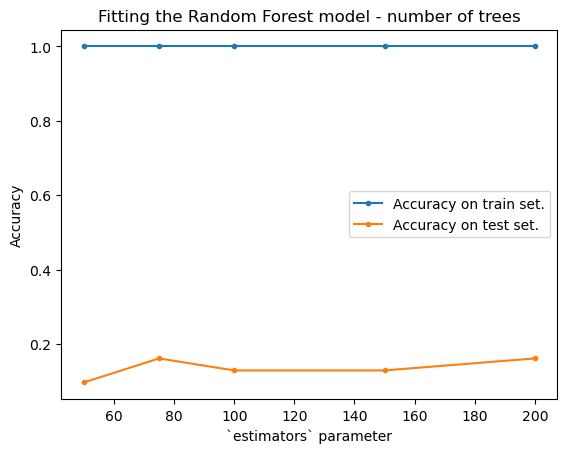

In [31]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - number of trees')
plt.xlabel('`estimators` parameter')
plt.ylabel('Accuracy')
plt.legend();

#### Max depth

In [32]:
accuracies_train = []
accuracies_test = []
params_grid = [5, 10, 15, 20, 25, 30]

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, class_weight='balanced_subsample', random_state=42)
    model.fit(X_train, Y_train )
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

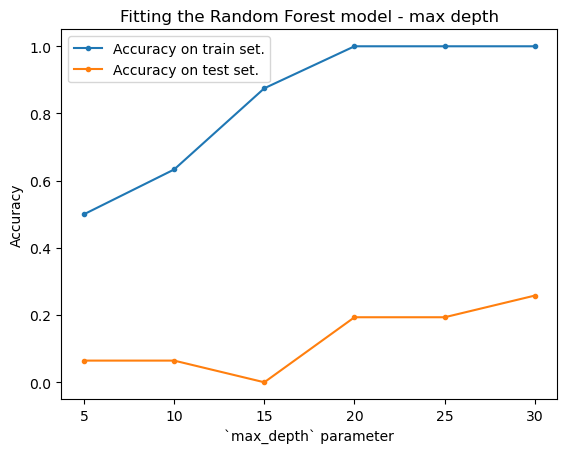

In [33]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - max depth')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

### GridSearch for number of trees and depth

In [34]:
model_rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [35]:
grid_search_cv = GridSearchCV(model_rf, {'n_estimators': [200, 300, 400], 'max_depth': [10, 12, 15, 17, 20]}, cv=3, scoring='accuracy')
grid_search_cv.fit(X_train, Y_train)

/Users/tatianadeferaudy/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_depth': [10, 12, 15, 17, 20],
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy')

In [36]:
grid_search_cv.best_score_

0.20833333333333334

In [37]:
grid_search_cv.best_params_

{'max_depth': 17, 'n_estimators': 400}

In [38]:
# So it takes a lot of trees to get to a relatively low accuracy 

# With the "best" parameters 

In [39]:
X= mod_df["text"]
y= mod_df["target"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [40]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = vectorizer.fit_transform(X).todense()
pd.set_option("display.max_rows", 10)
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(151, 43135)

In [41]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [42]:
model_rf = RandomForestClassifier(n_estimators=400, max_depth= 17, class_weight='balanced_subsample', random_state=42)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=17,
                       n_estimators=400, random_state=42)

In [43]:
y_pred = model_rf.predict(X_test)

In [44]:
accuracy_score(Y_test, y_pred)
# The improvement is actually based on the ngrams, and not huge ! 

0.21739130434782608

## Random Forest with TFID Vectorizer & ngrams

In [45]:
X= mod_df["text"]
y= mod_df["target"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [46]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(X).todense()
pd.set_option("display.max_rows", 10)
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(151, 9313)

In [47]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)
model_rf = RandomForestClassifier(n_estimators=200, max_depth= 20, random_state=42)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [48]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.17391304347826086

#### Based on checked best parameters

In [49]:
accuracies_train = []
accuracies_test = []
params_grid = range(10, 100)

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, class_weight='balanced_subsample', random_state=42)
    model.fit(X_train, Y_train )
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

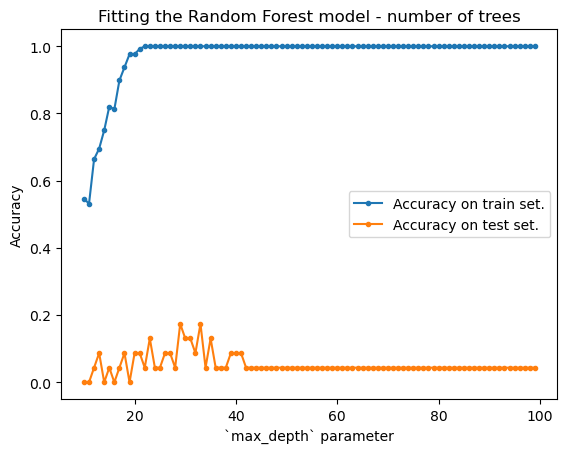

In [50]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - number of trees')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [51]:
accuracies_train = []
accuracies_test = []
params_grid = [200, 300, 400]

for param_value in params_grid:
    model = RandomForestClassifier(n_estimators=param_value, class_weight='balanced_subsample', random_state=42)
    model.fit(X_train, Y_train )
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

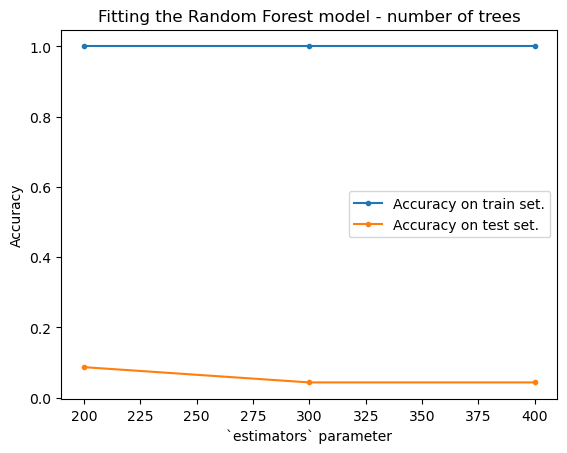

In [52]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - number of trees')
plt.xlabel('`estimators` parameter')
plt.ylabel('Accuracy')
plt.legend();

## Random Forest with imbalance handling

In [53]:
X= mod_df["text"]
y= mod_df["target"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [54]:
train = pd.concat([texts_train, Y_train],axis=1)
train.head(2)

,text,target
151,programme grande école mim skema business school enddate year 2025 startdate year 2021 classe ...,10
81,drawing painting charcoal sculpture art academy of cincinnati enddate year 1998 startdate year ...,2


In [55]:
print(len(train.target.unique()))
print(len(train))
#train.exp1_industry.value_counts()
unique_ind = train.text.unique()
ind_dict = {elem : pd.DataFrame() for elem in unique_ind}
for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

39
128


In [56]:
for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)
len(ind_dict)

128

In [57]:
newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

In [58]:
print(list(newtrain.target.value_counts()))

[272, 255, 221, 204, 153, 102, 102, 85, 68, 51, 51, 51, 34, 34, 34, 34, 34, 34, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


In [59]:
y_train_resampled = newtrain['target'].copy()
X_train_resampled = newtrain['text'].copy()

In [60]:
# trying other stuff in vectorizer 
# stripping accents doesn't seem to do much...  
# same for setting max_df at different ranges (0.5, 0.7, 0.8) 
# not many words seem to be shared in the corpus, which is odd. 

vectorizer = CountVectorizer(ngram_range=(1,2), strip_accents='unicode', max_df=0.7) 
vectors = vectorizer.fit_transform(X).todense()
pd.set_option("display.max_rows", 10)
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(151, 42829)

In [61]:
X_train = vectorizer.fit_transform(X_train_resampled)
X_test = vectorizer.transform(texts_test)

In [62]:
model_rf = RandomForestClassifier(n_estimators=400, max_depth= 30, random_state=42)
model_rf.fit(X_train, y_train_resampled)

RandomForestClassifier(max_depth=30, n_estimators=400, random_state=42)

In [63]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.21739130434782608

# ADDITIONAL STUFF TO TRY

Try nearest neighbors: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors  
And the associated user guide: https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors  
Given an array or dataframe of vectors (each row representing an item) and a new vector (just one row, representing the reference item chosen by the user), it will give you the k closest items (smallest distance).  


Text preparation issues : 
* remove numbers ? 
* impute industry for the missing ones 
* should some words have more weight than others ? 

### Notes for later : 
* cosine similarity instead of TDIF vectorizer ? 
* use PCA and make clusters of people ? 
* change the Y to 1/0 based on a civic tech list (e.g. the one that appears when creating companies SQL tables)
* work with companies' data to make clusters of similar companies and predict for that/ recommend closest neighbors (and NGOs)
